# Lecture 9

# Data Wrangling with Pandas

# Overview

In `Pandas` we saw that there are two (rather similar) core data structures:
* the one-dimensional **Series** object
* the two-dimensional **DataFrame** object 

Querying these data structures is done in a few different ways, such as 

* using the `iloc` or `loc` attributes for **row-based querying**
* using the square brackets on the object for **column-based querying**. 

We saw that we can query the **DataFrame** and **Series** objects through **Boolean masking**, which is a powerful filtering method that allows us to determine what data should be kept in our analysis.

Today, we are going to go into more detail on how to manipulate a **DataFrame**, in particular. 

We are going to explore how to 
* **join** data sets from multiple files together into one
* we reduce and process data using **groupby** and **apply**
* we talk about some Pandas features that are useful for both traditional **statistical analysis** and **machine learning**. 



# Section 1: Merging Dataframes

We have already seen how we **add new data** to an existing DataFrame. We simply use the square bracket operator with the new column name, and the data is added as long as an index is shared. 

If there is no shared index and a **scalar value** is passed in (a scalar value is just a single value like an integer or a string), the new value column is added with the scalar value as the default value. 

What if we wanted to assign a **different value for every row**? If we could hardcode the values into a list, then pandas will unpack them and assign them to the rows. But if the list we have isn't long enough, then we can't do this, since Pandas doesn't know where the missing values should go.

## Adding columns

We used the DataFrame of store purchases from our previous lecture, where the index is a list of stores and the columns store purchase data. 

In [1]:
import pandas as pd

df = pd.DataFrame([{'Name': 'Matthias', 'Item Purchased': 'Sponge', 'Cost': 22.50},
                   {'Name': 'Thomas', 'Item Purchased': 'Kitty Litter', 'Cost': 2.50},
                   {'Name': 'Christina', 'Item Purchased': 'Spoon', 'Cost': 5.00}],
                  index=['Store 1', 'Store 1', 'Store 2'])
df

,Name,Item Purchased,Cost
Store 1,Matthias,Sponge,22.5
Store 1,Thomas,Kitty Litter,2.5
Store 2,Christina,Spoon,5.0


If we want to add some new column called **Date** to the DataFrame, that's fine. We just use the square bracket operator directly on the DataFrame, as long as the column is as long as the rest of the records.

In [2]:
df['Date'] = ['December 1', 'January 1', 'mid-May']
df

,Name,Item Purchased,Cost,Date
Store 1,Matthias,Sponge,22.5,December 1
Store 1,Thomas,Kitty Litter,2.5,January 1
Store 2,Christina,Spoon,5.0,mid-May


If we want to add some new field, may be a delivery flag, that's easy too since it's a scalar value.

*The term "scalar" comes from linear algebra, where it is used to differentiate a single number from a vector or matrix. The meaning in computing is similar. It distinguishes a single value like an integer or float from a data structure like an array.*

In [3]:
df['Delivered'] = True
df

,Name,Item Purchased,Cost,Date,Delivered
Store 1,Matthias,Sponge,22.5,December 1,True
Store 1,Thomas,Kitty Litter,2.5,January 1,True
Store 2,Christina,Spoon,5.0,mid-May,True


The problem comes in when we have only a few items to add. In order for this to work, we have to supply pandas the list which is long enough for the DataFrame, so that each row could be populated. This means that we have to input none values ourselves.

In [4]:
df['Feedback'] = ['Positive', None, 'Negative']
df

,Name,Item Purchased,Cost,Date,Delivered,Feedback
Store 1,Matthias,Sponge,22.5,December 1,True,Positive
Store 1,Thomas,Kitty Litter,2.5,January 1,True,None
Store 2,Christina,Spoon,5.0,mid-May,True,Negative


If each of our rows has a unique index, then we could just assign the new column identifier to the series. For instance, if we reset the index with `df.reset_index()` in this example so the DataFrame is labeled from 0 through 2.

Then we create a new series with these labels, we can apply it. 

In [5]:
adf = df.reset_index()
adf['Date'] = pd.Series({0: '2. April', 2: '25. April'})
adf

,index,Name,Item Purchased,Cost,Date,Delivered,Feedback
0,Store 1,Matthias,Sponge,22.5,2. April,True,Positive
1,Store 1,Thomas,Kitty Litter,2.5,NaN,True,None
2,Store 2,Christina,Spoon,5.0,25. April,True,Negative


And the results we get are as we expected. The nice aspect of this approach is that we could just ignore the items that we don't know about, and pandas will put missing values in for us. So this is a really nice way to do it.

## Merge DataFrames

More commonly, we want to join two larger DataFrames together, and this is a bit more complex. Some terminology first:


**This is a Venn Diagram**

![Venn Diagram]( 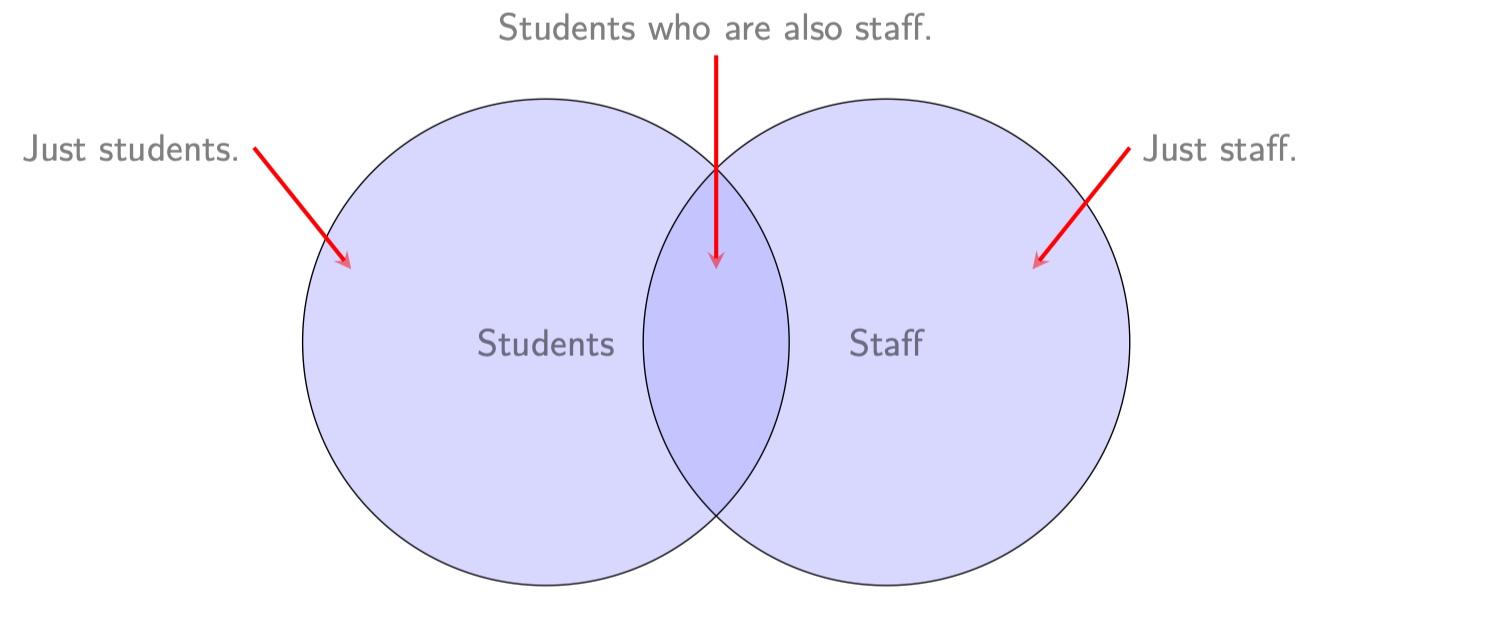)

A Venn Diagram is traditionally used to show set membership. For example, the circle on the left is the population of students at a university. 

The circle on the right is the population of staff at a university. And the overlapping region in the middle are all of those students who are also staff. Maybe these students run tutorials for a course, or grade assignments, or engage in running research experiments. 

We could think of these two populations as indices in separate DataFrames, maybe with the label of Person Name. When we want to join the DataFrames together, we have some choices to make. 

We will now discuss how to merge DataFrames.



* First we create two DataFrames, **students** and **staff**. 
* There is some overlap in these DataFrames, in that Thomas and Christina are both **students and staff**, but Myriam and Reto are not. 
* Importantly, both DataFrames are indexed along the value we want to merge them on, which is called **Name**.

In [6]:
# student DataFrame
student_df = pd.DataFrame([{'Name': 'Thomas', 'School': 'Computer Science'},
                           {'Name': 'Reto', 'School': 'Law'},
                           {'Name': 'Christina', 'School': 'Business'}])
student_df = student_df.set_index('Name')

# staff DataFrame
staff_df = pd.DataFrame([{'Name': 'Myriam', 'Role': 'Director of HR'},
                         {'Name': 'Christina', 'Role': 'Course liasion'},
                         {'Name': 'Thomas', 'Role': 'Grader'}])
staff_df = staff_df.set_index('Name')

In [7]:
student_df

,School
Name,
Thomas,Computer Science
Reto,Law
Christina,Business


In [8]:
staff_df

,Role
Name,
Myriam,Director of HR
Christina,Course liasion
Thomas,Grader


First what if we want a list of all the people regardless of whether they're staff or student, and all of the information we can get on them? 

### Outer Join

In database terminology, this is called a **full outer join**. And in set theory, it's called a **union**. In the Venn diagram, it represents everyone in any circle.

![Outer Join]( 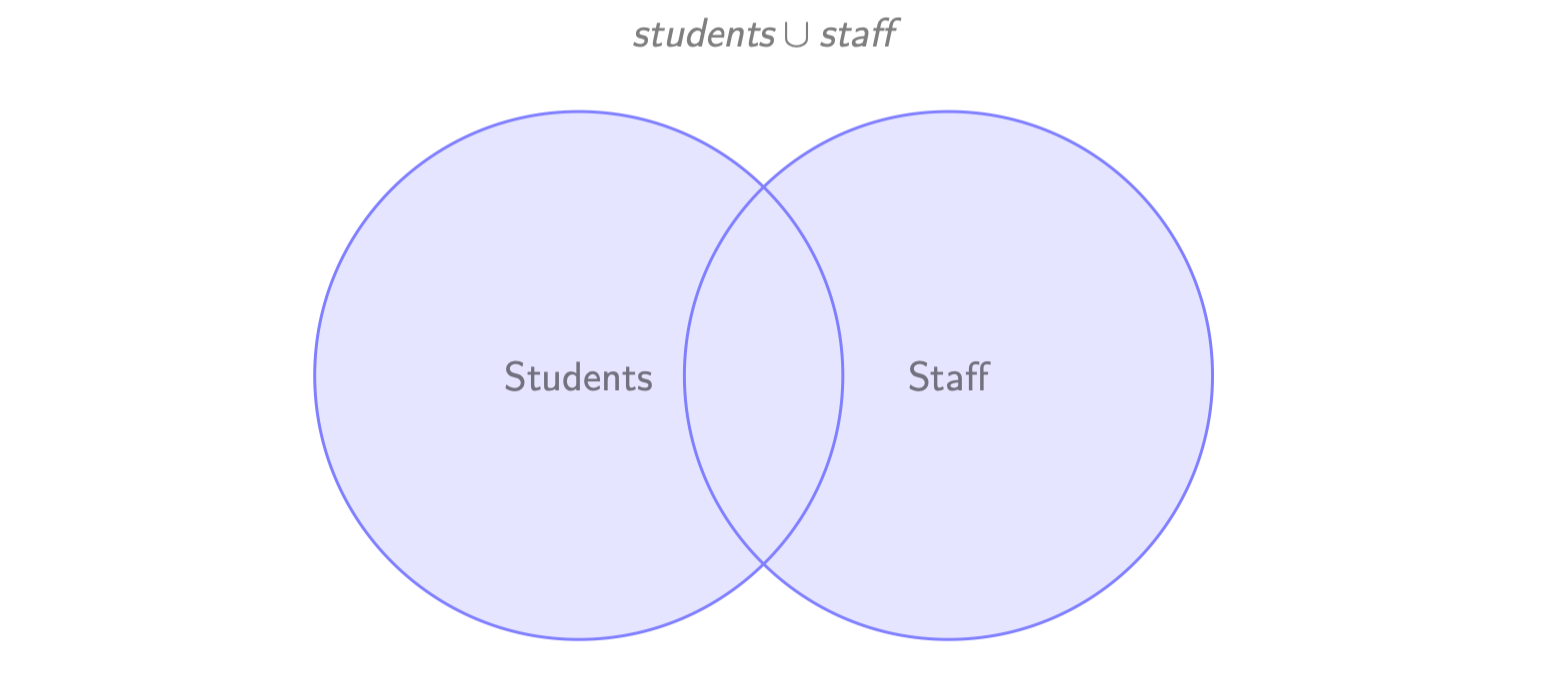)

If we want the union of these, we would call `merge` passing in the DataFrame on the left and the DataFrame on the right, and telling merge that we want it to use an `outer` join. We tell merge that we want to use the left and right indices as the joining columns.


In [9]:
pd.merge(student_df, staff_df, how='outer', left_index=True, right_index=True)

,School,Role
Name,,
Christina,Business,Course liasion
Myriam,NaN,Director of HR
Reto,Law,NaN
Thomas,Computer Science,Grader


We see in the resulting DataFrame that everyone is listed. And since Reto does not have a role, and Myriam does not have a school, those cells are listed as missing values. 

### Inner Join

What if we only want those people who we have maximum information on, those people who are both staff and students. In database terminology, this is called an **inner join**. Or in set theory, the **intersection**. And this is represented in the Venn diagram as the overlapping parts of each circle.

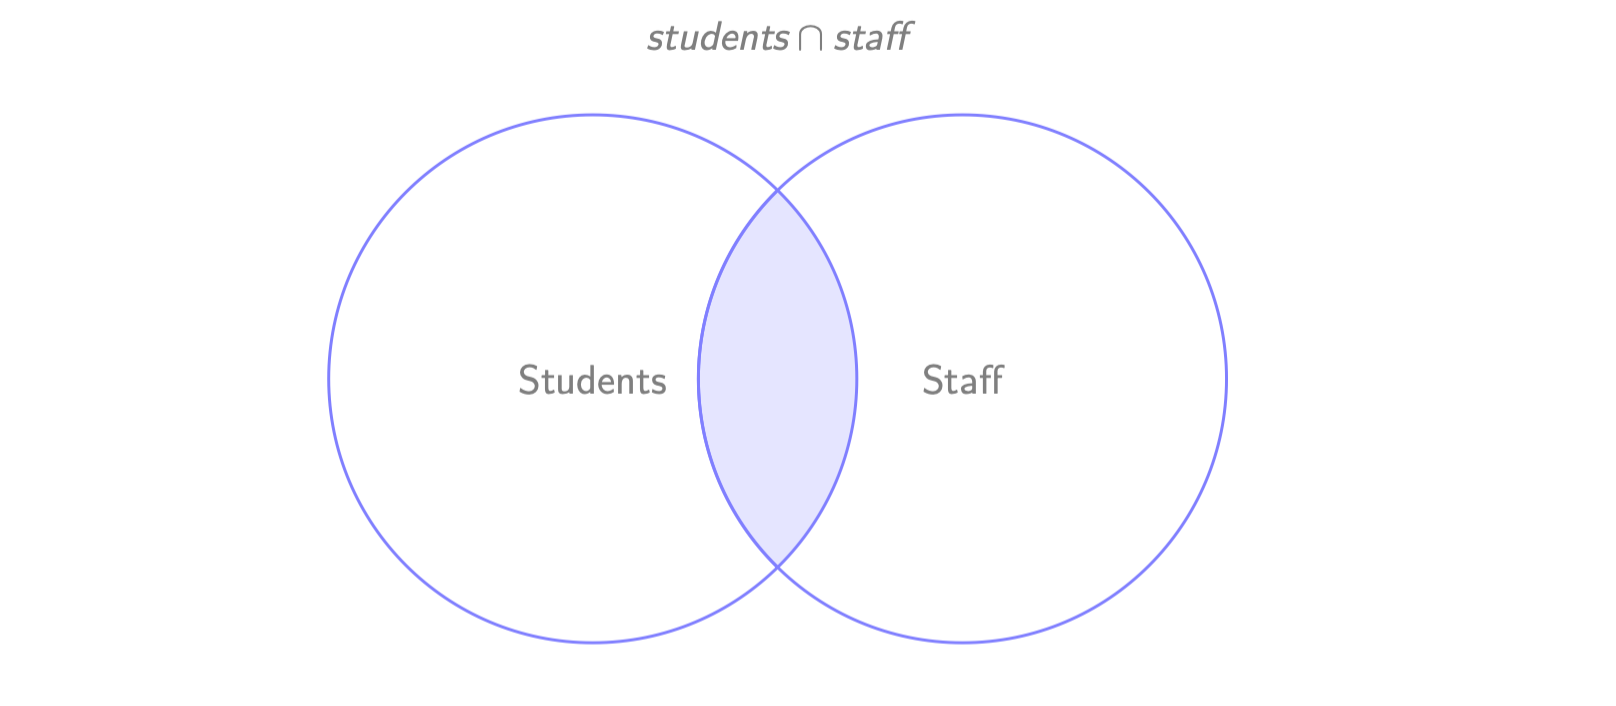

If we want to get the intersection, that is, just those students who are also staff, we could set the how attribute to `inner`. 

In [10]:
pd.merge(student_df, staff_df, how='inner', left_index=True, right_index=True)

,School,Role
Name,,
Thomas,Computer Science,Grader
Christina,Business,Course liasion


And we see the resulting DataFrame has only Christina and Thomas in it.

The **Inner Join** is the simplest join and is the most commonly used-as we did in the SQL sessions.

### Set Addition

Now there are two other other use cases when merging DataFrames. Both are examples of what we call set addition. 

#### Left Join

Here we would want to get a list of all students regardless of whether they were staff or not. But if they were staff, we would want to get their staff details as well. To do this we would use a left join.

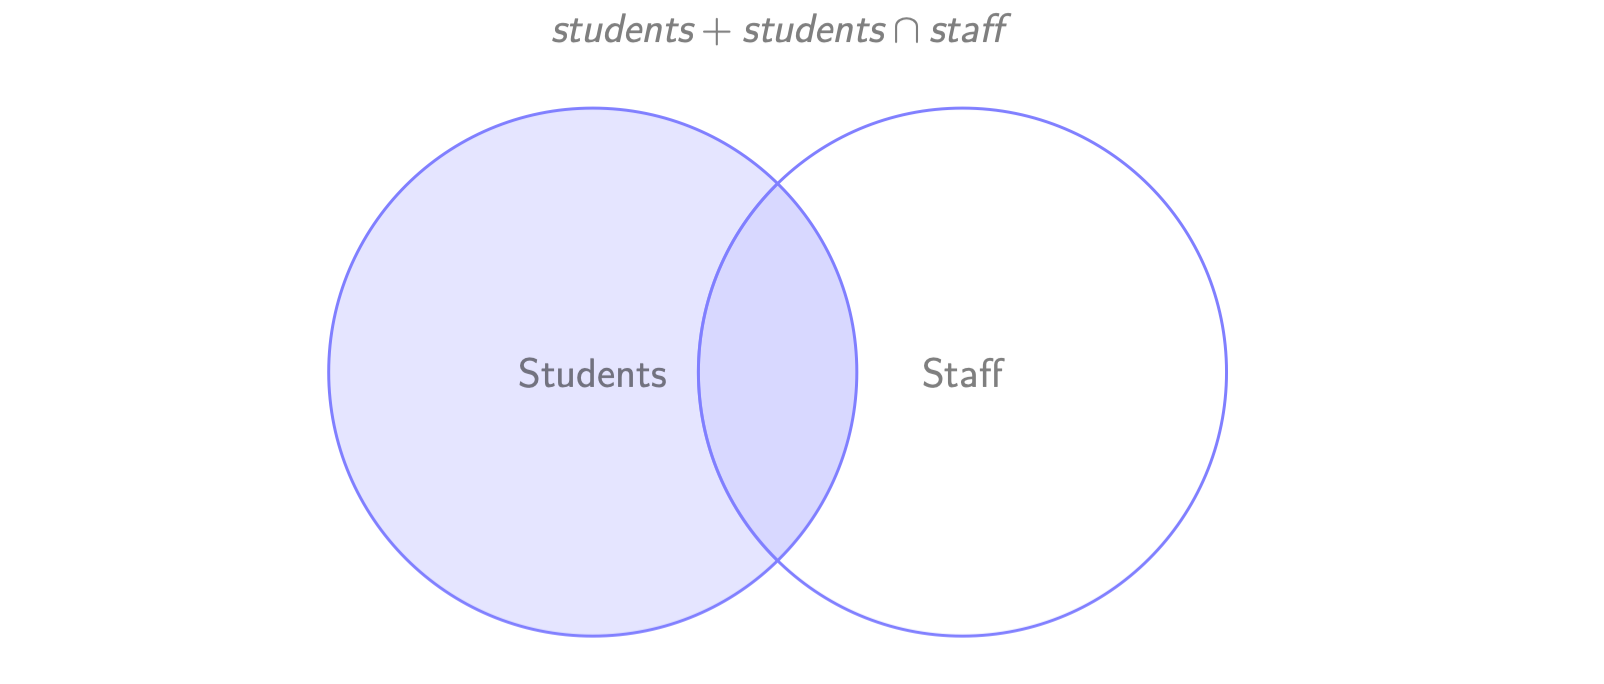

In [11]:
pd.merge(student_df, staff_df, how='left', left_index=True, right_index=True)

,School,Role
Name,,
Thomas,Computer Science,Grader
Reto,Law,NaN
Christina,Business,Course liasion


#### Right join

![Right Join]( 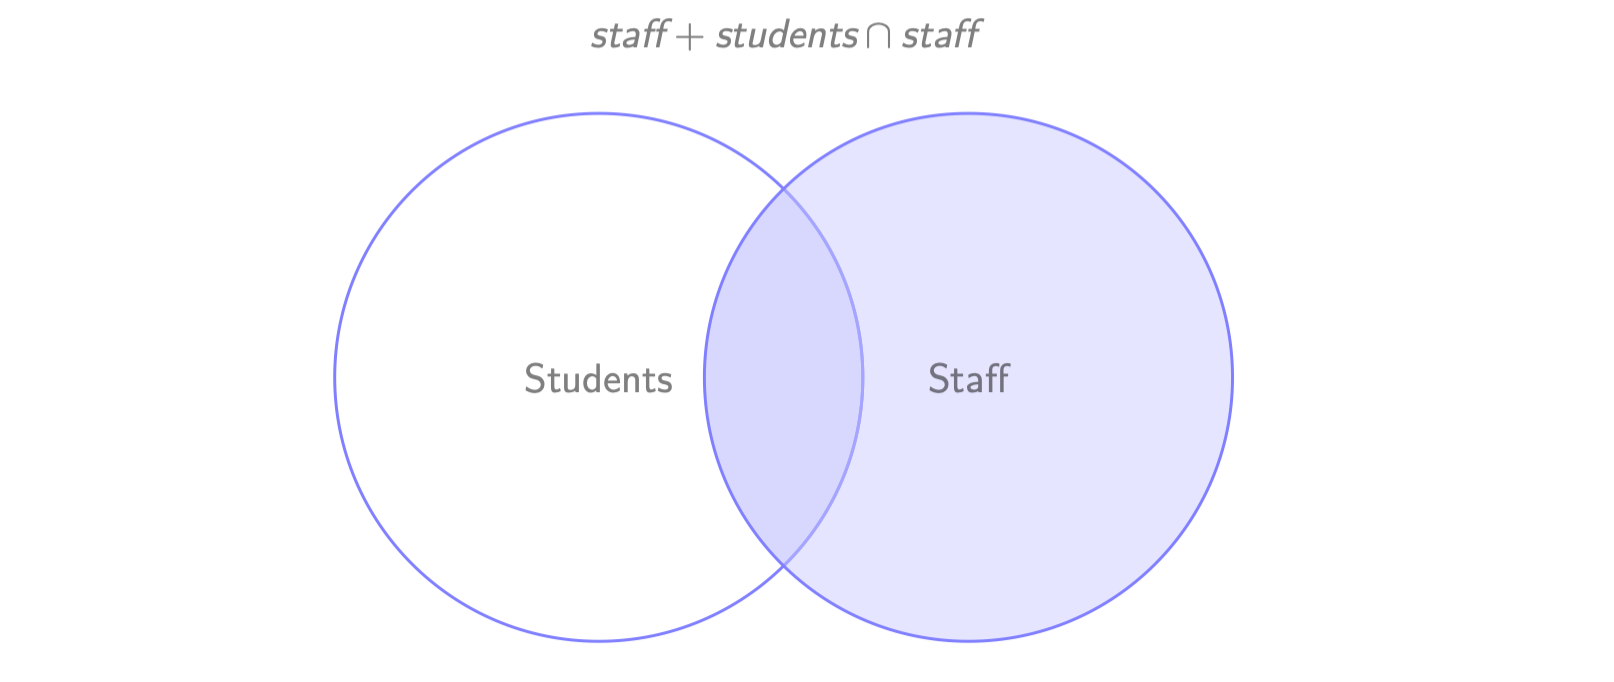)

We want a list of all of the staff and their school if they were also students. To do this we would do a right join.

In [12]:
pd.merge(student_df, staff_df, how='right', left_index=True, right_index=True)

,School,Role
Name,,
Myriam,NaN,Director of HR
Christina,Business,Course liasion
Thomas,Computer Science,Grader


## Join on Column not Index

The merge method has a couple of other interesting parameters. First, you do not need to use indices to join on, you can use columns as well. Here's an example.

In [13]:
staff_df = staff_df.reset_index()
student_df = student_df.reset_index()
pd.merge(staff_df, student_df, how='outer', left_on='Name', right_on='Name')

,Name,Role,School
0,Myriam,Director of HR,NaN
1,Christina,Course liasion,Business
2,Thomas,Grader,Computer Science
3,Reto,NaN,Law


## Conflicts between DataFrames

So what happens when we have conflicts between the DataFrames? 


Let's create new student and staff DataFrames that have **location information** added to them. 
* in the staff DataFrame, this is an **office location** where we can find the staff person
* for the student DataFrame, the location information is their **home address**.

In [14]:
student_df = pd.DataFrame([{'Name': 'Thomas', 'School': 'Computer Science', 'Location': 'Museumsstrasse'},
                           {'Name': 'Reto', 'School': 'Law', 'Location': 'Poststrasse'},
                           {'Name': 'Christina', 'School': 'Business', 'Location': 'Spisergasse'}])

staff_df = pd.DataFrame([{'Name': 'Myriam', 'Role': 'Director of HR', 'Location': 'Dufourstrasse'},
                         {'Name': 'Christina', 'Role': 'Course liasion', 'Location': 'Bodanstrasse'},
                         {'Name': 'Thomas', 'Role': 'Grader', 'Location': 'Rosenbergstrasse'}])


In [15]:
pd.merge(student_df, staff_df, how='outer', left_on='Name', right_on='Name')

,Name,School,Location_x,Role,Location_y
0,Thomas,Computer Science,Museumsstrasse,Grader,Rosenbergstrasse
1,Reto,Law,Poststrasse,NaN,NaN
2,Christina,Business,Spisergasse,Course liasion,Bodanstrasse
3,Myriam,NaN,NaN,Director of HR,Dufourstrasse


The merge function preserves this information, but appends an `_x` or `_y` to help differentiate between which index went with which column of data. The `_x` is always the left DataFrame information, and the `_y` is always the right DataFrame information.


## Multi-indexing and Multiple columns

It's quite possible that the **first name** for students and staff might overlap, but the **last name** might not. In this case, we use a list of the multiple columns that should be used to join keys on the left_on and right_on parameters. Here we use `First Name` and `Last Name` for the Join.

In [16]:
staff_df = pd.DataFrame([{'First Name': 'Myriam', 'Last Name': 'Müller', 'Role': 'Director of HR'},
                         {'First Name': 'Christina', 'Last Name': 'Meier', 'Role': 'Course liasion'},
                         {'First Name': 'Thomas', 'Last Name': 'Abraham', 'Role': 'Grader'}])
student_df = pd.DataFrame([{'First Name': 'Thomas', 'Last Name': 'Mayer', 'School': 'Business'},
                           {'First Name': 'Reto', 'Last Name': 'Kurz', 'School': 'Law'},
                           {'First Name': 'Christina', 'Last Name': 'Meier', 'School': 'Business'}])

In [17]:
student_df

,First Name,Last Name,School
0,Thomas,Mayer,Business
1,Reto,Kurz,Law
2,Christina,Meier,Business


In [18]:
staff_df

,First Name,Last Name,Role
0,Myriam,Müller,Director of HR
1,Christina,Meier,Course liasion
2,Thomas,Abraham,Grader


In [20]:
pd.merge(student_df, staff_df, how='inner', left_on=['First Name','Last Name'], right_on=['First Name','Last Name'])

,First Name,Last Name,School,Role
0,Christina,Meier,Business,Course liasion


In [26]:
pd.merge(student_df, staff_df, how='outer', left_on=['First Name'], right_on=['Last Name'])

,First Name_x,Last Name_x,School,First Name_y,Last Name_y,Role
0,Thomas,Mayer,Business,NaN,NaN,NaN
1,Reto,Kurz,Law,NaN,NaN,NaN
2,Christina,Meier,Business,NaN,NaN,NaN
3,NaN,NaN,NaN,Myriam,Müller,Director of HR
4,NaN,NaN,NaN,Christina,Meier,Course liasion
5,NaN,NaN,NaN,Thomas,Abraham,Grader


As you see here, Thomas Abraham and Thomas Mayer don't match on both keys. So the inner join does not include these individuals in the output, and only Christina Maier is retained. 


Pandas has a lot more options in the area, but the merge function may be the easiest to understand and the most flexible. 